# Prerequisite

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
from evaluate.preprocess import normalize, draw_normal_distribution, check_feature_corr

# Preprocessing

In [3]:
train_data = pd.read_csv("dataset/train.csv")
test_data = pd.read_csv("dataset/test.csv")

## Normalization

In [4]:
X_data, y_data = train_data.drop(columns=["EP", "ID"]), train_data[["EP"]]

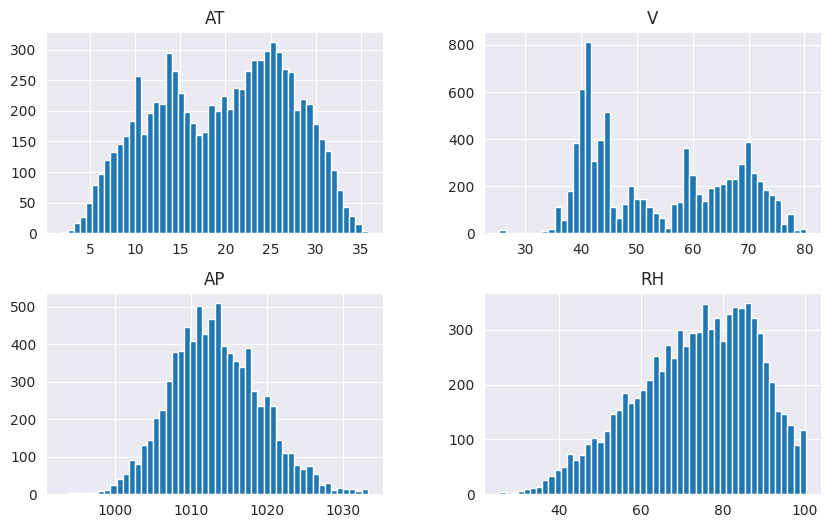

In [5]:
draw_normal_distribution(X_data, columns=X_data.columns)

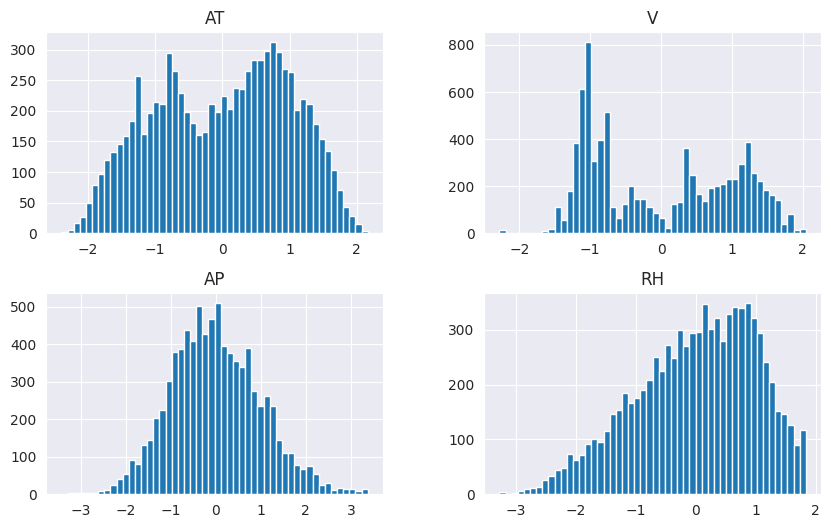

In [6]:
# normalizing
X_data = normalize(X_data, columns=X_data.columns)
draw_normal_distribution(X_data, columns=X_data.columns)

## Splitting

In [7]:
# splitting
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)
X_pred = test_data.drop(columns=["ID"])
X_pred = normalize(X_pred, columns=X_pred.columns)
len(X_data), len(X_train), len(X_test), len(X_pred)

(8500, 5695, 2805, 1068)

# Analysis

## Missing Values

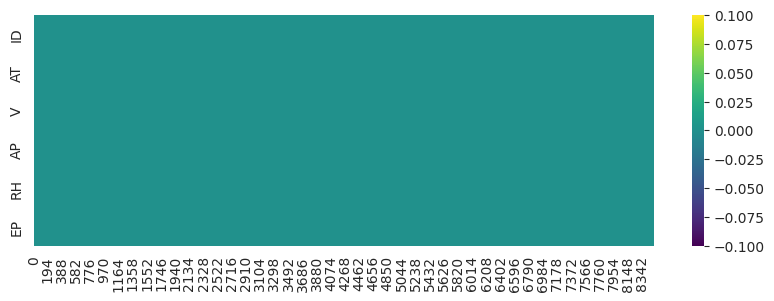

In [8]:
# check for missing values
plt.figure(figsize=(10, 3))
sns.heatmap(train_data.transpose().isnull(), cbar=True, cmap='viridis')
plt.show()

## Find correlations

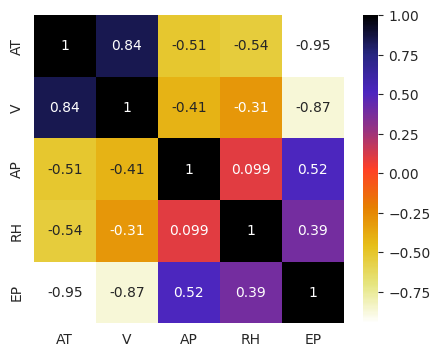

In [9]:
# Pearson Correlation
corr = pd.concat([X_data, y_data], axis=1).corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr, cmap=plt.cm.CMRmap_r, annot=True)
plt.show()

# Feature Selection

In [10]:
# feature_corr = check_feature_corr(X_data, threshold=0.6)

In [11]:
# X_train = X_train.drop(columns=['RH'])
# X_test = X_test.drop(columns=['RH'])
# X_pred = X_pred.drop(columns=['RH'])

# Model Training & Comparison

In [12]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate model using MSE, MAE, R2-score
    :param model: model
    :param X_train: training features
    :param y_train: training labels
    :param X_test: testing features
    :param y_test: testing labels
    :return: {mse, mae, r2}
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'mse': mse, 'mae': mae, 'r2': r2}

In [13]:
# Evaluation Results
def result_to_table(name, _result):
    return pd.DataFrame.from_dict({
        'MODEL': [name],
        'MSE': [_result['mse']],
        'MAE': [_result['mae']],
        'R2': [_result['r2']]
    })

## Linear Regression

In [14]:
# linear regression
linear_model = LinearRegression()
result = evaluate_model(
    model=linear_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)
linear_results = result_to_table("linear", result)
linear_results

,MODEL,MSE,MAE,R2
0,linear,21.279954,3.604155,0.928093


## Polynomial Regression

In [15]:
def create_polynomial_features(deg, X):
    poly = PolynomialFeatures(degree=deg)
    return poly.fit_transform(X)

In [16]:
poly_results = None
for i in range(2, 12):
    model=LinearRegression()
    result = evaluate_model(
        model=model,
        X_train=create_polynomial_features(i, X_train),
        X_test=create_polynomial_features(i, X_test),
        y_train=y_train,
        y_test=y_test,
    )
    if poly_results is None:
        poly_results = result_to_table(f'poly{i}', result)
    else:
        poly_results = pd.concat([poly_results, result_to_table(f'poly{i}', result)])
    print(f'Polynomial Regression Degree {i}')

Polynomial Regression Degree 2
Polynomial Regression Degree 3
Polynomial Regression Degree 4
Polynomial Regression Degree 5
Polynomial Regression Degree 6
Polynomial Regression Degree 7
Polynomial Regression Degree 8
Polynomial Regression Degree 9
Polynomial Regression Degree 10
Polynomial Regression Degree 11


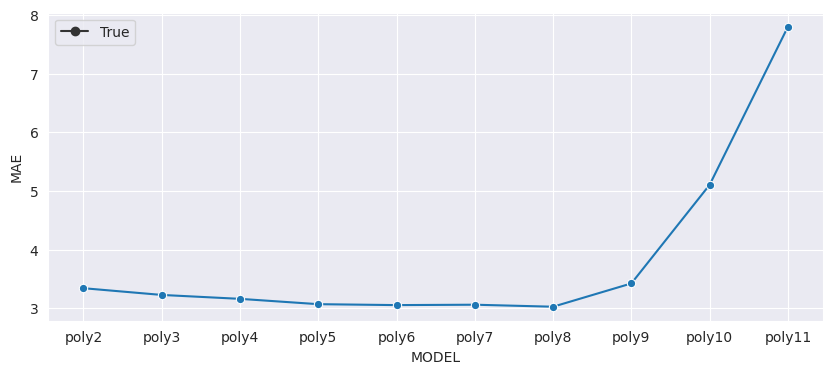

In [17]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=poly_results['MODEL'], y=poly_results['MAE'], markers=True, style=True)
plt.show()

# Predictions

In [18]:
test_data

,ID,AT,V,AP,RH
0,8501,8.91,40.69,1015.11,89.65
1,8502,25.63,48.92,1009.99,34.64
2,8503,18.98,60.10,1010.09,85.34
3,8504,8.02,39.04,1018.49,68.07
4,8505,34.10,73.03,1014.01,41.26
...,...,...,...,...,...
1063,9564,31.73,74.67,1016.38,44.51
1064,9565,29.18,71.43,1011.65,59.49
1065,9566,18.87,52.05,1012.02,53.46
1066,9567,28.85,71.32,1009.09,76.90


In [23]:
# polynomial regression model with degree 8
poly8 = LinearRegression()
poly8.fit(
    X=create_polynomial_features(8, X_data),
    y=y_data
)
pred = poly8.predict(create_polynomial_features(8, X_pred))
pred = pd.DataFrame({
    'ID': test_data['ID'],
    'EP': pred.flatten()
})
pred.to_csv('submission/predictions.csv', index=False)
pred

,ID,EP
0,8501,480.097379
1,8502,445.422122
2,8503,451.430701
3,8504,482.812199
4,8505,433.871789
...,...,...
1063,9564,431.337765
1064,9565,434.394163
1065,9566,456.149051
1066,9567,433.450220
